Before beginning this exercise you must download some data files, which can be retrieved from here: 

https://northwestern.box.com/s/rsb5wjb7dztg2128flzgex4fmq19havu

Be sure to move the corresponding files to the directory where you are running this notebook. Furthermore, you will need to provide the path to these data as the variable `dataDir`, below.

In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import numpy as np
import matplotlib.pyplot as plt

from rhlUtils import BBox, CCD, Image, imshow

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

dataDir = # complete

I've provided you with two datasets ("bias.npz" and "bias2.npz") which are the trimmed image of a CCD from the PFS project.  One has had a bias frame subtracted, one has not.  This "bias frame" is the average of many bias exposures, each of which has had the overscan level subtracted (it was measured by looking at the serial overscan pixels, which are now trimmed).

You can read the data into an Image, and the Image object is also able to return a view of the data from a single
amplifier (in the range 0..7).  For example, you can say:

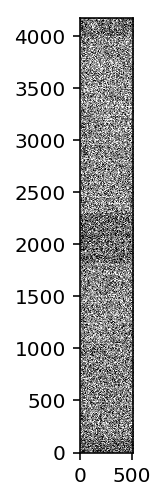

In [21]:
bias = Image(os.path.join(dataDir, "bias.npz"))

aim = bias.getAmpImage(6)

plt.clf()
imshow(aim)     # or you can use plt.imshow if you'd prefer;  imshow is imported from rhlUtils
plt.show();

Take a look at the entire image.  Hint:  each amplifier has its own gain

Which do you think had a bias frame subtracted?  Why?

---

You probably started by plotting one of the images; that looks something like:

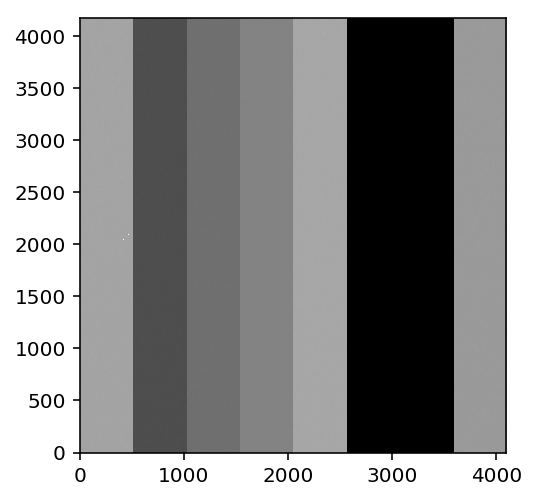

In [22]:
bias = Image(os.path.join(dataDir, "bias.npz"))

plt.clf()
imshow(bias.image)
plt.show();

The 8 amplifiers all have different gain, so we'll subtract off the median values

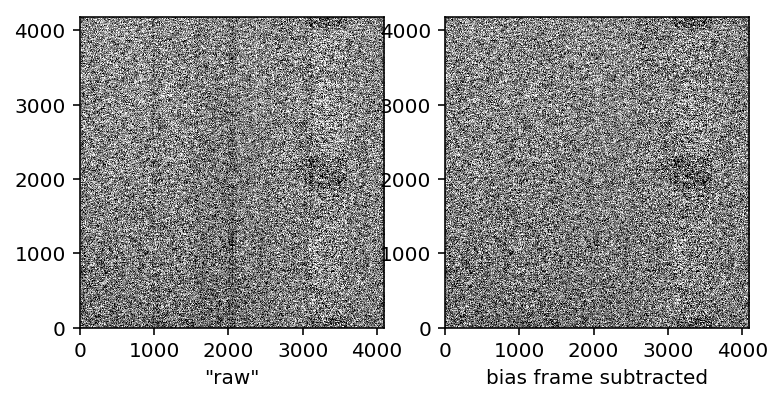

In [51]:
biases = [
    ("\"raw\"",               Image(os.path.join(dataDir, "bias.npz"))),   # No bias frame subtracted
    ("bias frame subtracted", Image(os.path.join(dataDir, "bias2.npz"))),  # bias frame was subtracted
]
for title, bias in biases:
    for amp in bias.amps:
        aim = bias.getAmpImage(amp)
        aim -= np.median(aim)

plt.clf()
plt.subplot(1, 2, 1)
imshow(biases[0][1].image)
plt.xlabel(biases[0][0])

plt.subplot(1, 2, 2)
imshow(biases[1][1].image)
plt.xlabel(biases[1][0]);

There's more structure in the left hand image, which is the (stable) signature of the electronics.  This isn't all that surprising when you remember that the serial registers are run, and the pixels digitised, just after a parallel transfer so the electronics is in a different state at the beginning and end of the serial readout.

We'll use the bias-subtracted data, `bias2.npz`

---

Write a program to measure the power spectrum of each amplifier separately (but plot them all together).

Each row of the data corresponds to a row of the CCD clocked onto the serial register -- but remember that we have trimmed the data to throw away the extended register and overclock.  The CCD object has the magic numbers you need to correct for this:
-    `rawWidth = 552`                      # number of pixels digitised per parallel transfer
-    `tau_s = 13.92e-6`                    # Time for one serial transfer (s)
-    `tau_p = 222.72e-6`                   # Time for one parallel transfer (s)

There is also some junk in the data (e.g. cosmic rays, transients at the bottom of the chip) that might affect your results -- a simple n-sigma clip might help.

If you've never calculated a power spectrum before you might need some help.  There is code in `scipy.signal` to do it, but it's a little tricky.  The power spectrum should be essentially flat (but not exactly flat).

Which amplifier has the worst low-frequency behaviour?  Was that what you expected?

In [52]:
import scipy.signal

bias = Image(os.path.join(dataDir, "bias2.npz"))

for amp in bias.amps:
    aim = bias.getAmpImage(amp)
    aim -= np.median(aim)

Your first attempt probably looked rather like this:

P.S. I set the power spectrum at zero frequency to be `NaN` as it's the mean and isn't interesting -- we forced it to be practically zero by subtracting the median.

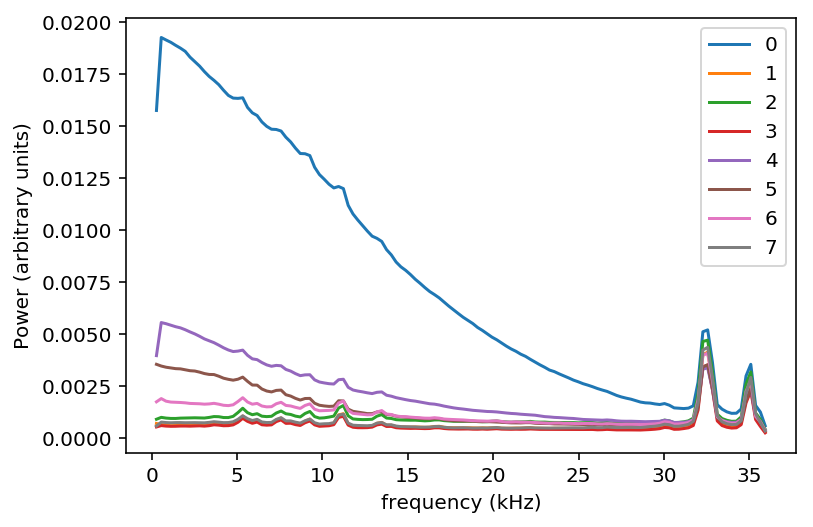

In [55]:
plt.figure(1)
plt.clf()

times = None
windowPS = None
for ampNo in range(len(bias.amps)):
    amp = bias.amps[ampNo]
    dat = bias.getAmpImage(amp).flatten()
    
    f, PS = scipy.signal.welch(dat, 1/CCD.tau_s)

    PS[0] = np.NaN   # we subtracted the median

    plt.plot(1e-3*f, PS, label=str(ampNo))
    
plt.xlabel("frequency (kHz)")
plt.ylabel("Power (arbitrary units)")
plt.legend(loc='best')
plt.show();

That doesn't make a lot of sense;  why does amp 0 (which looks pretty innocuous) look so bad?  Let's look at the data:

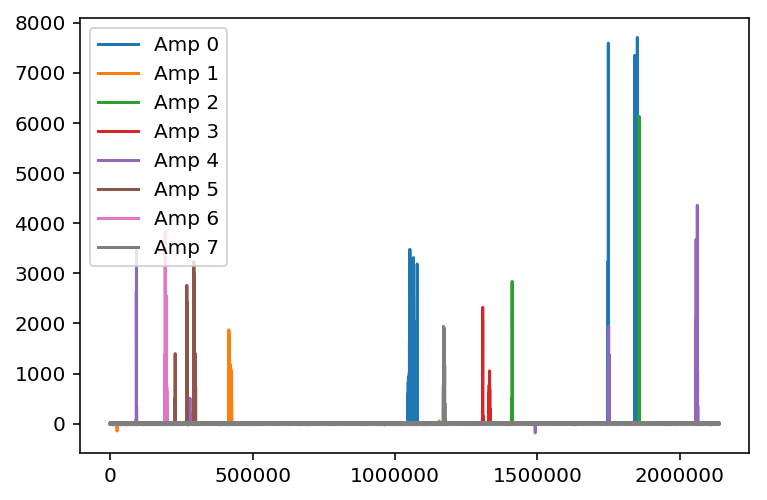

In [60]:
ampNo = 0
for ampNo in range(8):
    plt.plot(bias.getAmpImage(ampNo).flatten(), label="Amp %d" % ampNo)
plt.legend(loc='upper left');

Those outlier pixels are worrying and they'll dominate the power spectrum -- so let's remove them.  I'll use a sigma-clip, starting with a robust estimate for the standard deviation (for a Gaussian, it's around 0.741*(interquartile range) and that's what I'll use here).  We don't remove the values (that'd break the uniform sampling of the data), but simply replace it by the limit.

In [69]:
def removeOutliers(dat, nSigma=5)
    """Remove bad values using a sigma-clip"""

    q1, q3 = np.percentile(dat, [25, 75])
    stdev = 0.741*(q3 - q1)

    val = -nSigma*stdev
    dat[dat < val ] = val

    val =  nSigma*stdev
    dat[dat > val ] = val

SyntaxError: invalid syntax (<ipython-input-69-f23f839620ab>, line 1)

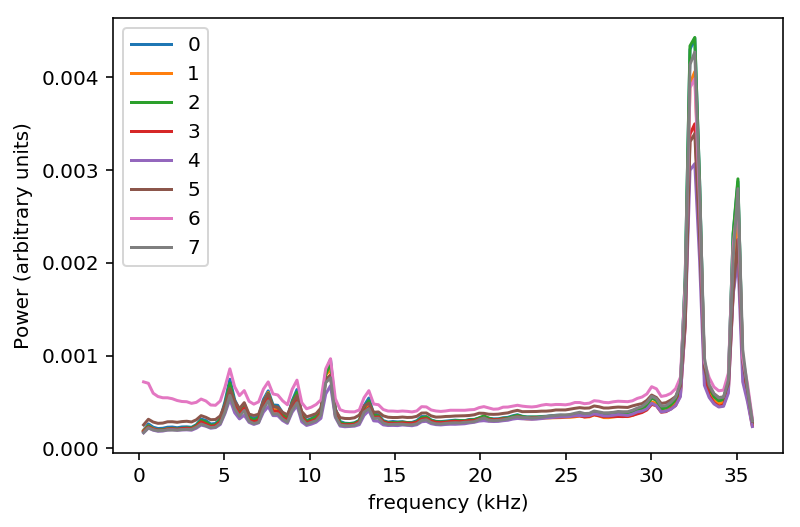

In [61]:
plt.figure(1)
plt.clf()

times = None
windowPS = None
for ampNo in range(len(bias.amps)):
    amp = bias.amps[ampNo]
    dat = bias.getAmpImage(amp).copy().flatten()

    dat -= np.median(dat)
    removeOutliers(dat)

    f, PS = scipy.signal.welch(dat, 1/CCD.tau_s)
    PS[0] = np.NaN   # we subtracted the median

    plt.plot(1e-3*f, PS, label=str(ampNo))
    
plt.xlabel("frequency (kHz)")
plt.ylabel("Power (arbitrary units)")
plt.legend(loc='best')
plt.show();

Much better.  The bad amp (6, which showed banding i.e. excess power on long time scales) is clearly the worst behaved at low fequencies.

However, where are those extra features around 10 kHz coming from?  The features above 30 kHz are plausibly due to the serial electronics (I don't know if Jim Gunn agrees).

One possibility is that I just flattened the data, but that means that the time sampling isn't uniform.  Let's try replacing the missing data with $N(0, \sigma^2)$ and see if that helps:

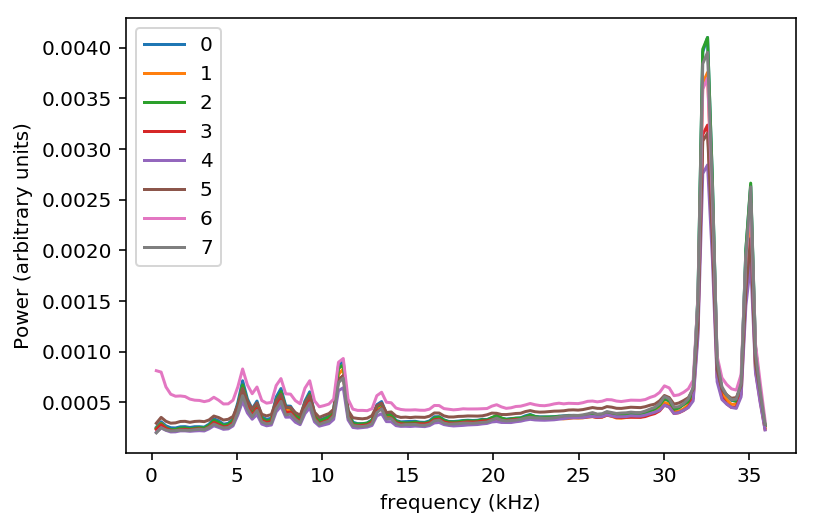

In [62]:
plt.figure(1)
plt.clf()

times = None
windowPS = None
for ampNo in range(len(bias.amps)):
    amp = bias.amps[ampNo]
    dat = bias.getAmpImage(amp).copy().flatten()
    dat -= np.median(dat)
    #
    # Remove bad values using a sigma-clip
    #
    q1, q3 = np.percentile(dat, [25, 75])
    stdev = 0.741*(q3 - q1)

    nSigma = 5
    val = -nSigma*stdev
    dat[dat < val ] = val

    val =  nSigma*stdev
    dat[dat > val ] = val

    width = amp.size[0]
    rw = int(width + (CCD.tau_p + CCD.tau_s*(CCD.rawWidth - width))/CCD.tau_s) # effective number of serial samples
    pdat = np.zeros(len(dat)*rw//width)   # data with padding

    q1, med, q3 = np.percentile(dat, [25, 50, 75])
    stdev = 0.741*(q3 - q1)
    pdat += np.random.normal(med, stdev, size=len(pdat))
    j = 0  # index into pdat;
    for i in range(amp.size[1]):
        pdat[j:j+width] = dat[i*width:(i + 1)*width]
        j += rw
    f, PS = scipy.signal.welch(pdat, 1/CCD.tau_s)

    PS[0] = np.NaN   # we subtracted the median

    plt.plot(1e-3*f, PS, label=str(ampNo))
    
plt.xlabel("frequency (kHz)")
plt.ylabel("Power (arbitrary units)")
plt.legend(loc='best')
plt.show();

Oh dear; not much difference.  The way that people like Kepler fill in their gaps is by using a Gaussian Process, but I'm going to do something by brute force.

It'd be nice to fill in the gaps and use an FFT, but you can Fourier transform non-uniformly sampled data.  A way to do this is by using the Lomb-Scargle algorithm (often used for finding periods of variable stars).  Unfortunately this is an $N^2$ algorithm and although there are $N\ln N$ variations the one in `scipy` isn't especially fast.

We used Welch's algorithm to estimate our power spectrum for uniformly sampled data but there's no similar package that I know of for Lomb-Scargle FTs, so we'll have to be a bit careful.  The problem with estimating power spectra is that longer time series have discrete Fourier transforms that are more finely sampled but each mode is no better measured so we'll have to average.  I've chosen to do this in a rather simplistic (i.e. slow!) way.  Try `nSample == 1`, `10`, and `100` (which will take a while!)

Another difference is that `scipy.signal.welch` handles detrending and windowing for you, but here we need to do it ourselves.

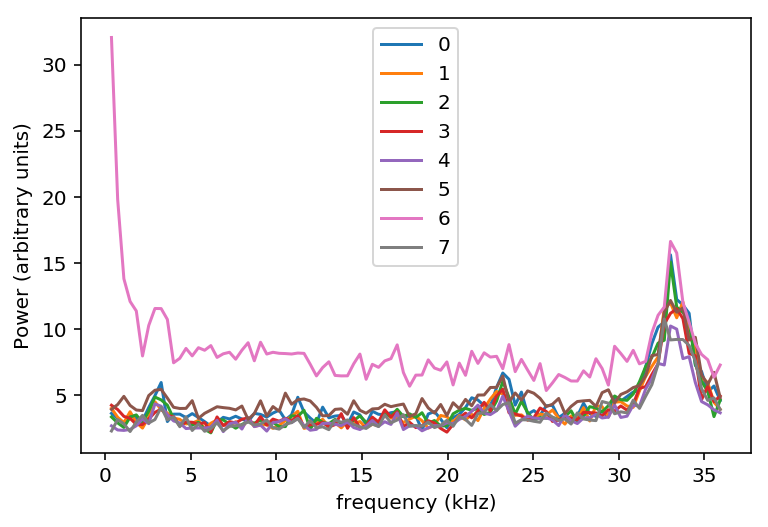

In [68]:
import scipy.signal

bias = Image(os.path.join(dataDir, "bias2.npz"))

plt.figure(1)
plt.clf()

nSample = 1       # number of samples of power spectrum

times = None      # time sample values; calculated for the first amp we process
windowPS = None   # the window; calculated at the same time as times
for ampNo in range(len(bias.amps)):
    amp = bias.amps[ampNo]
    dat = bias.getAmpImage(amp).copy().flatten()
    dat -= np.median(dat)
    #
    # Remove bad values using a sigma-clip
    #
    q1, q3 = np.percentile(dat, [25, 75])
    stdev = 0.741*(q3 - q1)

    nSigma = 5
    val = -nSigma*stdev
    dat[dat < val ] = val

    val =  nSigma*stdev
    dat[dat > val ] = val
    
    dat = dat.astype('float64')         # scipy.signal.lombscargle only works on doubles

    if times is None:
        f = np.linspace(0, 0.5/CCD.tau_s, 100)[1:]
        width = amp.size[0]
        i = np.arange(len(dat))
        times = CCD.tau_s*i + (CCD.tau_p + CCD.tau_s*(CCD.rawWidth - width))*i//width
        window = scipy.signal.get_window('hamming', len(dat))

    dat = scipy.signal.detrend(dat)
    dat *= window

    PS = 0
    for df in np.linspace(0, f[1], nSample):
        PS += scipy.signal.lombscargle(times, dat, f + df)
    PS /= nSample

    plt.plot(1e-3*f, PS, label=str(ampNo))
    
plt.xlabel("frequency (kHz)")
plt.ylabel("Power (arbitrary units)")
plt.legend(loc='best')
plt.show();

That looks much better (especially if you had the patience to wait for `nSample == 100`).  The power spectrum is readonably flat, except for amp 6, although with the pronounced peak at c. 33kHz, and some signs of trouble at c. 3kHZ and 23kHz.